In [1]:
from tensorflow import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
class_names = {0:'Normal', 1:'Suprventricular', 2:'Ventricular', 3:'Fusion', 4:'Unknown'}
num_classes = 5
epochs = 25

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the train data and test data

In [4]:
train_file = "/content/drive/My Drive/mitbih_train.csv"
test_file = "/content/drive/My Drive/mitbih_test.csv"
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

Organize Data into their Classifications:

Method for organizing data into their classifications. This is done to better understand the dataset sparsity.

In [5]:
def generateBins(data):
  bins = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
  for i in range(len(data)):
    bins[data.iloc[i][187]] += 1
  print(bins)

In [6]:
train_bins = generateBins(train_data)
test_bins = generateBins(test_data)

{0: 72470, 1: 2223, 2: 5788, 3: 641, 4: 6431}
{0: 18117, 1: 556, 2: 1448, 3: 162, 4: 1608}


Splitting Data:

Datasets are split between the ECG readings, x_train, and classification, y_train. The test dataset is split in the same way. x_train and x_test are reshaped to be valid with a convolutional neural network.

In [7]:
x_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

x_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

x_train.reshape(len(x_train), x_train.shape[1], 1)
x_test.reshape(len(x_test), x_test.shape[1], 1)

array([[[0.90842491],
        [0.7838828 ],
        [0.53113556],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.73008847],
        [0.21238938],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.91041666],
        [0.68124998],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[1.        ],
        [0.96735907],
        [0.62017804],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.98412699],
        [0.5674603 ],
        [0.60714287],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.97396964],
        [0.91323209],
        [0.86550975],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

Plotting ECG Readings:

Plots of the first 25 ECG readings in the dataset

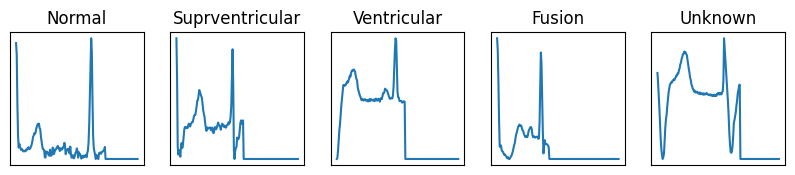

In [8]:
plt.figure(figsize=(10,10))
x_plots = []
y_plots = []
for i in range(len(x_train)):
  if(y_train[i] == 0):
    if(len(x_plots) == 1):
      continue
    x_plots.append(x_train[i])
    y_plots.append(y_train[i])
  if(y_train[i] == 1):
    if(len(x_plots) == 2):
      continue
    x_plots.append(x_train[i])
    y_plots.append(y_train[i])
  if(y_train[i] == 2):
    if(len(x_plots) == 3):
      continue
    x_plots.append(x_train[i])
    y_plots.append(y_train[i])
  if(y_train[i] == 3):
    if(len(x_plots) == 4):
      continue
    x_plots.append(x_train[i])
    y_plots.append(y_train[i])
  if(y_train[i] == 4):
    x_plots.append(x_train[i])
    y_plots.append(y_train[i])
    break

for i in range(5):
    plt.subplot(5,5,i+1)

    axis = plt.gca()
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plt.plot((x_plots[i]))
    plt.title((class_names[y_plots[i]]))
plt.show()

CNN Model:

Model uses a 1D convolutional neural network. The network uses two stacks with two layers each. Activation used for the conbolutional layers is relu. A dropout of 0.25 is used. Optimizer used compile was adam.

In [11]:
def first_cnn():
  model = Sequential()

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))


  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  return model

In [12]:
def second_cnn():
  model = Sequential()

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187, 1)))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))


  model.add(Dense(5, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  return model

Training the Model:

Train the model and save the best model iteration. Model trains with previous created x_train, and y_train data. Model is trained over 25 epochs. Model is validated with x_test and y_test data. Lastly, the training and validation accuracies are plotted as well as the loss.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 185, 64)           256       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 92, 64)            0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 92, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 5888)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                376896    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                      

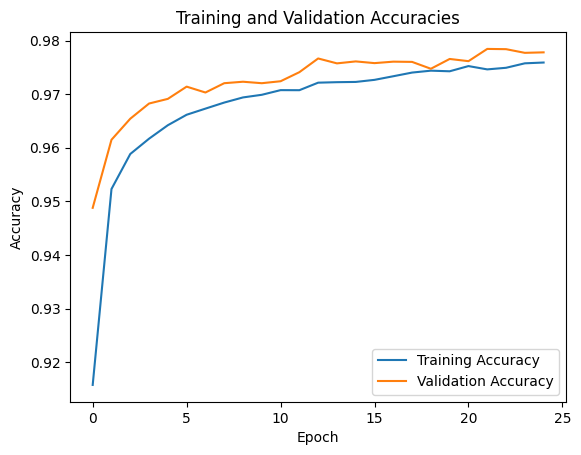

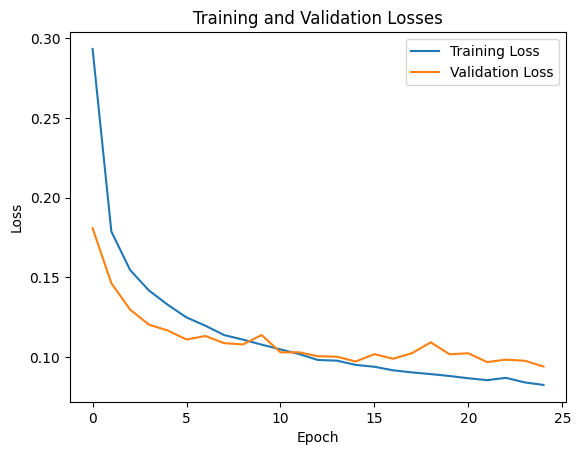

685/685 [==============================] - 2s 2ms/step - loss: 0.0968 - accuracy: 0.9784
Loss 0.09682885557413101
Test accuracy 0.9784386157989502


In [15]:
history_activations = dict()
current_base = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
model = first_cnn()
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[current_base], validation_data=(x_test,y_test))

fig1, acc=plt.subplots()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

fig2, acc=plt.subplots()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

best_model = load_model('best_model.h5')
scores = best_model.evaluate(x_test, y_test, verbose=1)
print('Loss {}'.format(scores[0]))
print('Test accuracy {}'.format(scores[1]))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 185, 64)           256       
                                                                 
 conv1d_11 (Conv1D)          (None, 183, 64)           12352     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 91, 64)            0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 91, 64)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 89, 64)            12352     
                                                                 
 conv1d_13 (Conv1D)          (None, 87, 64)            12352     
                                                      

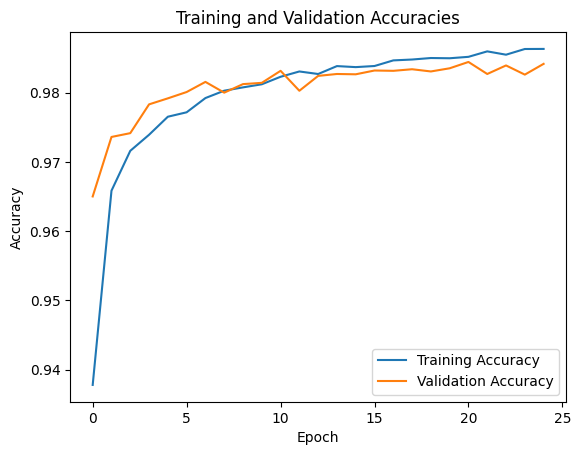

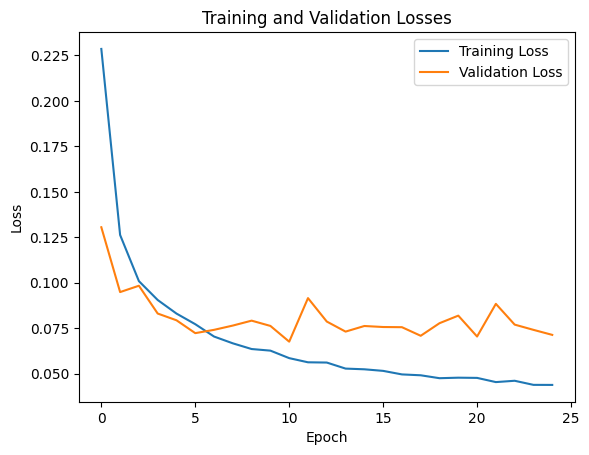

685/685 [==============================] - 2s 3ms/step - loss: 0.0705 - accuracy: 0.9844
Loss 0.07046974450349808
Test accuracy 0.9844228029251099


In [16]:
history_activations = dict()
current_base = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
model = second_cnn()
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[current_base], validation_data=(x_test,y_test))

fig1, acc=plt.subplots()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

fig2, acc=plt.subplots()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

best_model = load_model('best_model.h5')
scores = best_model.evaluate(x_test, y_test, verbose=1)
print('Loss {}'.format(scores[0]))
print('Test accuracy {}'.format(scores[1]))